# Метрики качества классификации

Мы очень много говорили про то, что оценка качества класиификатора не ограничивается только долей верно спрогнозированных меток. Настало время детально разобрать как же именно можно оценивать качество работы классификаторов.

Данные для иллюстрации взяты из **Kaggle** соревнования [Give me some credit](https://www.kaggle.com/c/GiveMeSomeCredit#description)

## Импорт библиотек

In [8]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

from sklearn.dummy import DummyClassifier

sns.set_style('whitegrid')
%matplotlib inline

## Загрузка данных

In [9]:
training_data = pd.read_csv('data/training_data.csv')
test_data = pd.read_csv('data/test_data.csv')

In [10]:
training_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      5001 non-null   int64  
 1   RevolvingUtilizationOfUnsecuredLines  5001 non-null   float64
 2   age                                   5001 non-null   int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  5001 non-null   int64  
 4   DebtRatio                             5001 non-null   float64
 5   MonthlyIncome                         4031 non-null   float64
 6   NumberOfOpenCreditLinesAndLoans       5001 non-null   int64  
 7   NumberOfTimes90DaysLate               5001 non-null   int64  
 8   NumberRealEstateLoansOrLines          5001 non-null   int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  5001 non-null   int64  
 10  NumberOfDependents                    4859 non-null   float64
dtypes: float64(4), in

In [11]:
training_data.keys()

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [12]:
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,5001.0,0.060988,0.239332,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,5001.0,3.842957,117.415101,0.0,0.030053,0.163463,0.556134,6324.0
age,5001.0,52.128374,14.907257,21.0,41.000000,52.000000,63.000000,99.0
NumberOfTime30-59DaysPastDueNotWorse,5001.0,0.355729,3.178306,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,5001.0,368.032252,2593.676885,0.0,0.177007,0.365727,0.829553,168835.0
MonthlyIncome,4031.0,6554.690151,7058.453424,0.0,3454.500000,5333.000000,8167.500000,208333.0
NumberOfOpenCreditLinesAndLoans,5001.0,8.383323,5.111950,0.0,5.000000,8.000000,11.000000,46.0
NumberOfTimes90DaysLate,5001.0,0.194361,3.132956,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,5001.0,1.022795,1.107556,0.0,0.000000,1.000000,2.000000,17.0
NumberOfTime60-89DaysPastDueNotWorse,5001.0,0.165167,3.111899,0.0,0.000000,0.000000,0.000000,98.0


### Обработка пропущенных значений

Проверим данные на пропуски. При наличии пропусков в датасете есть 2 пути: выкинуть данные, где есть пропуски и заполнить пропущенные значения. Убирать прецеденты с пропусками стоит только если относительно небольшая доля наблюдений имеет пропуски. Пропуски в данных можно заполнять разными методами:
- выборочной статистикой (среднее, медиана)
- прогнозами регрессии по известным признакам

Посмотрим на количество пропусков в данных

In [13]:
training_data.isna().sum()

SeriousDlqin2yrs                          0
RevolvingUtilizationOfUnsecuredLines      0
age                                       0
NumberOfTime30-59DaysPastDueNotWorse      0
DebtRatio                                 0
MonthlyIncome                           970
NumberOfOpenCreditLinesAndLoans           0
NumberOfTimes90DaysLate                   0
NumberRealEstateLoansOrLines              0
NumberOfTime60-89DaysPastDueNotWorse      0
NumberOfDependents                      142
dtype: int64

In [14]:
test_data.isna().sum()

SeriousDlqin2yrs                           0
RevolvingUtilizationOfUnsecuredLines       0
age                                        0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
MonthlyIncome                           1006
NumberOfOpenCreditLinesAndLoans            0
NumberOfTimes90DaysLate                    0
NumberRealEstateLoansOrLines               0
NumberOfTime60-89DaysPastDueNotWorse       0
NumberOfDependents                       143
dtype: int64

Пропуски есть только в столбце `MonthlyIncome` и составляют около 20% и в `NumberOfDependents`. Заполним значения медианой на обучающей выборке.

In [15]:
train_median = training_data.median()

In [16]:
training_data.fillna(train_median, inplace=True)

test_data.fillna(train_median, inplace=True)

Убедимся, что пропусков больше нет.

In [17]:
print(training_data.isna().sum())

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


In [18]:
print(test_data.isna().sum())

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


### Обработка аномальных значений

По `describe` видно, что есть записи, у которых `MonthlyIncome` и `DebtRatio` в области максимальных значений значительно отличаются от общего датасета. Отсечем точки, которые находятся за 99 квантилем.

In [19]:
training_data = training_data[training_data['MonthlyIncome'] < training_data['MonthlyIncome'].quantile(0.99)]
training_data = training_data[training_data['DebtRatio'] < training_data['DebtRatio'].quantile(0.99)]
training_data = training_data[training_data['RevolvingUtilizationOfUnsecuredLines'] < training_data['RevolvingUtilizationOfUnsecuredLines'].quantile(0.99)]

In [20]:
test_data = test_data[test_data['MonthlyIncome'] < test_data['MonthlyIncome'].quantile(0.99)]
test_data = test_data[test_data['DebtRatio'] < test_data['DebtRatio'].quantile(0.99)]
test_data = test_data[test_data['RevolvingUtilizationOfUnsecuredLines'] < test_data['RevolvingUtilizationOfUnsecuredLines'].quantile(0.99)]

Сравним распределения данных между наборами. К сожалению, без дополнительного "кода"
наложить гистограммы друг на друга пока нельзя.

Визуализируем матрицу корреляций

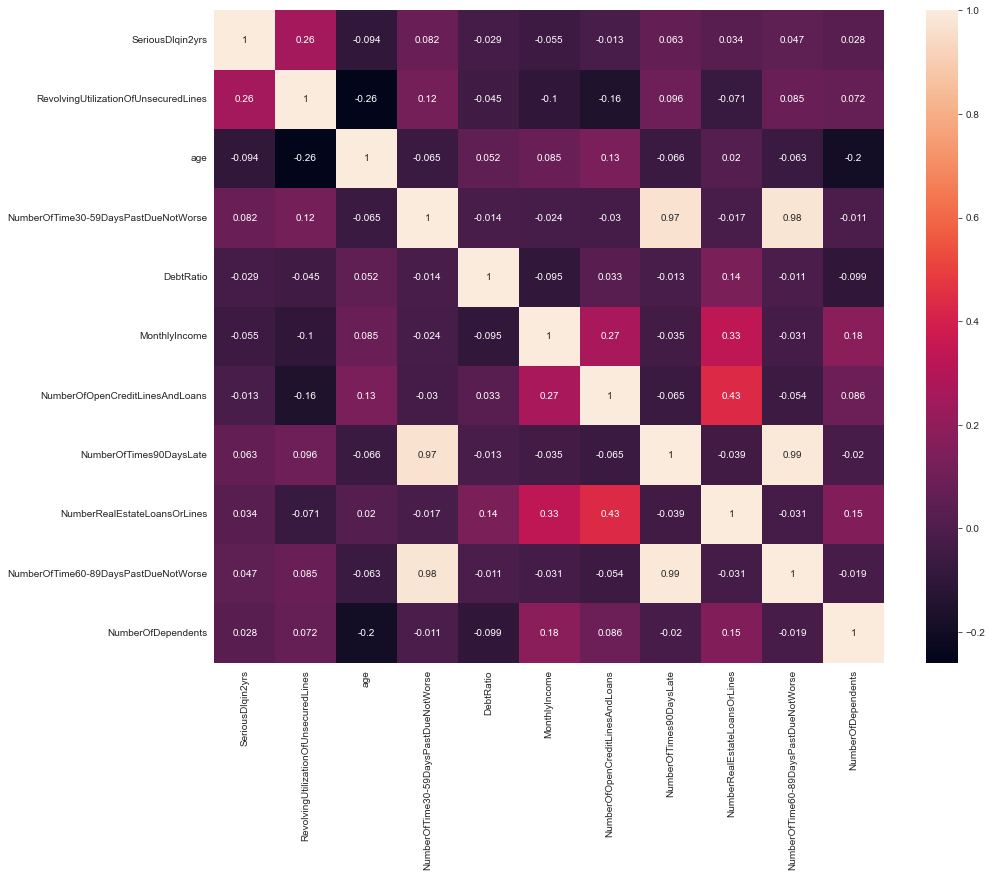

In [21]:
plt.figure(figsize=(15,12))
sns.heatmap(training_data.corr(), annot=True);

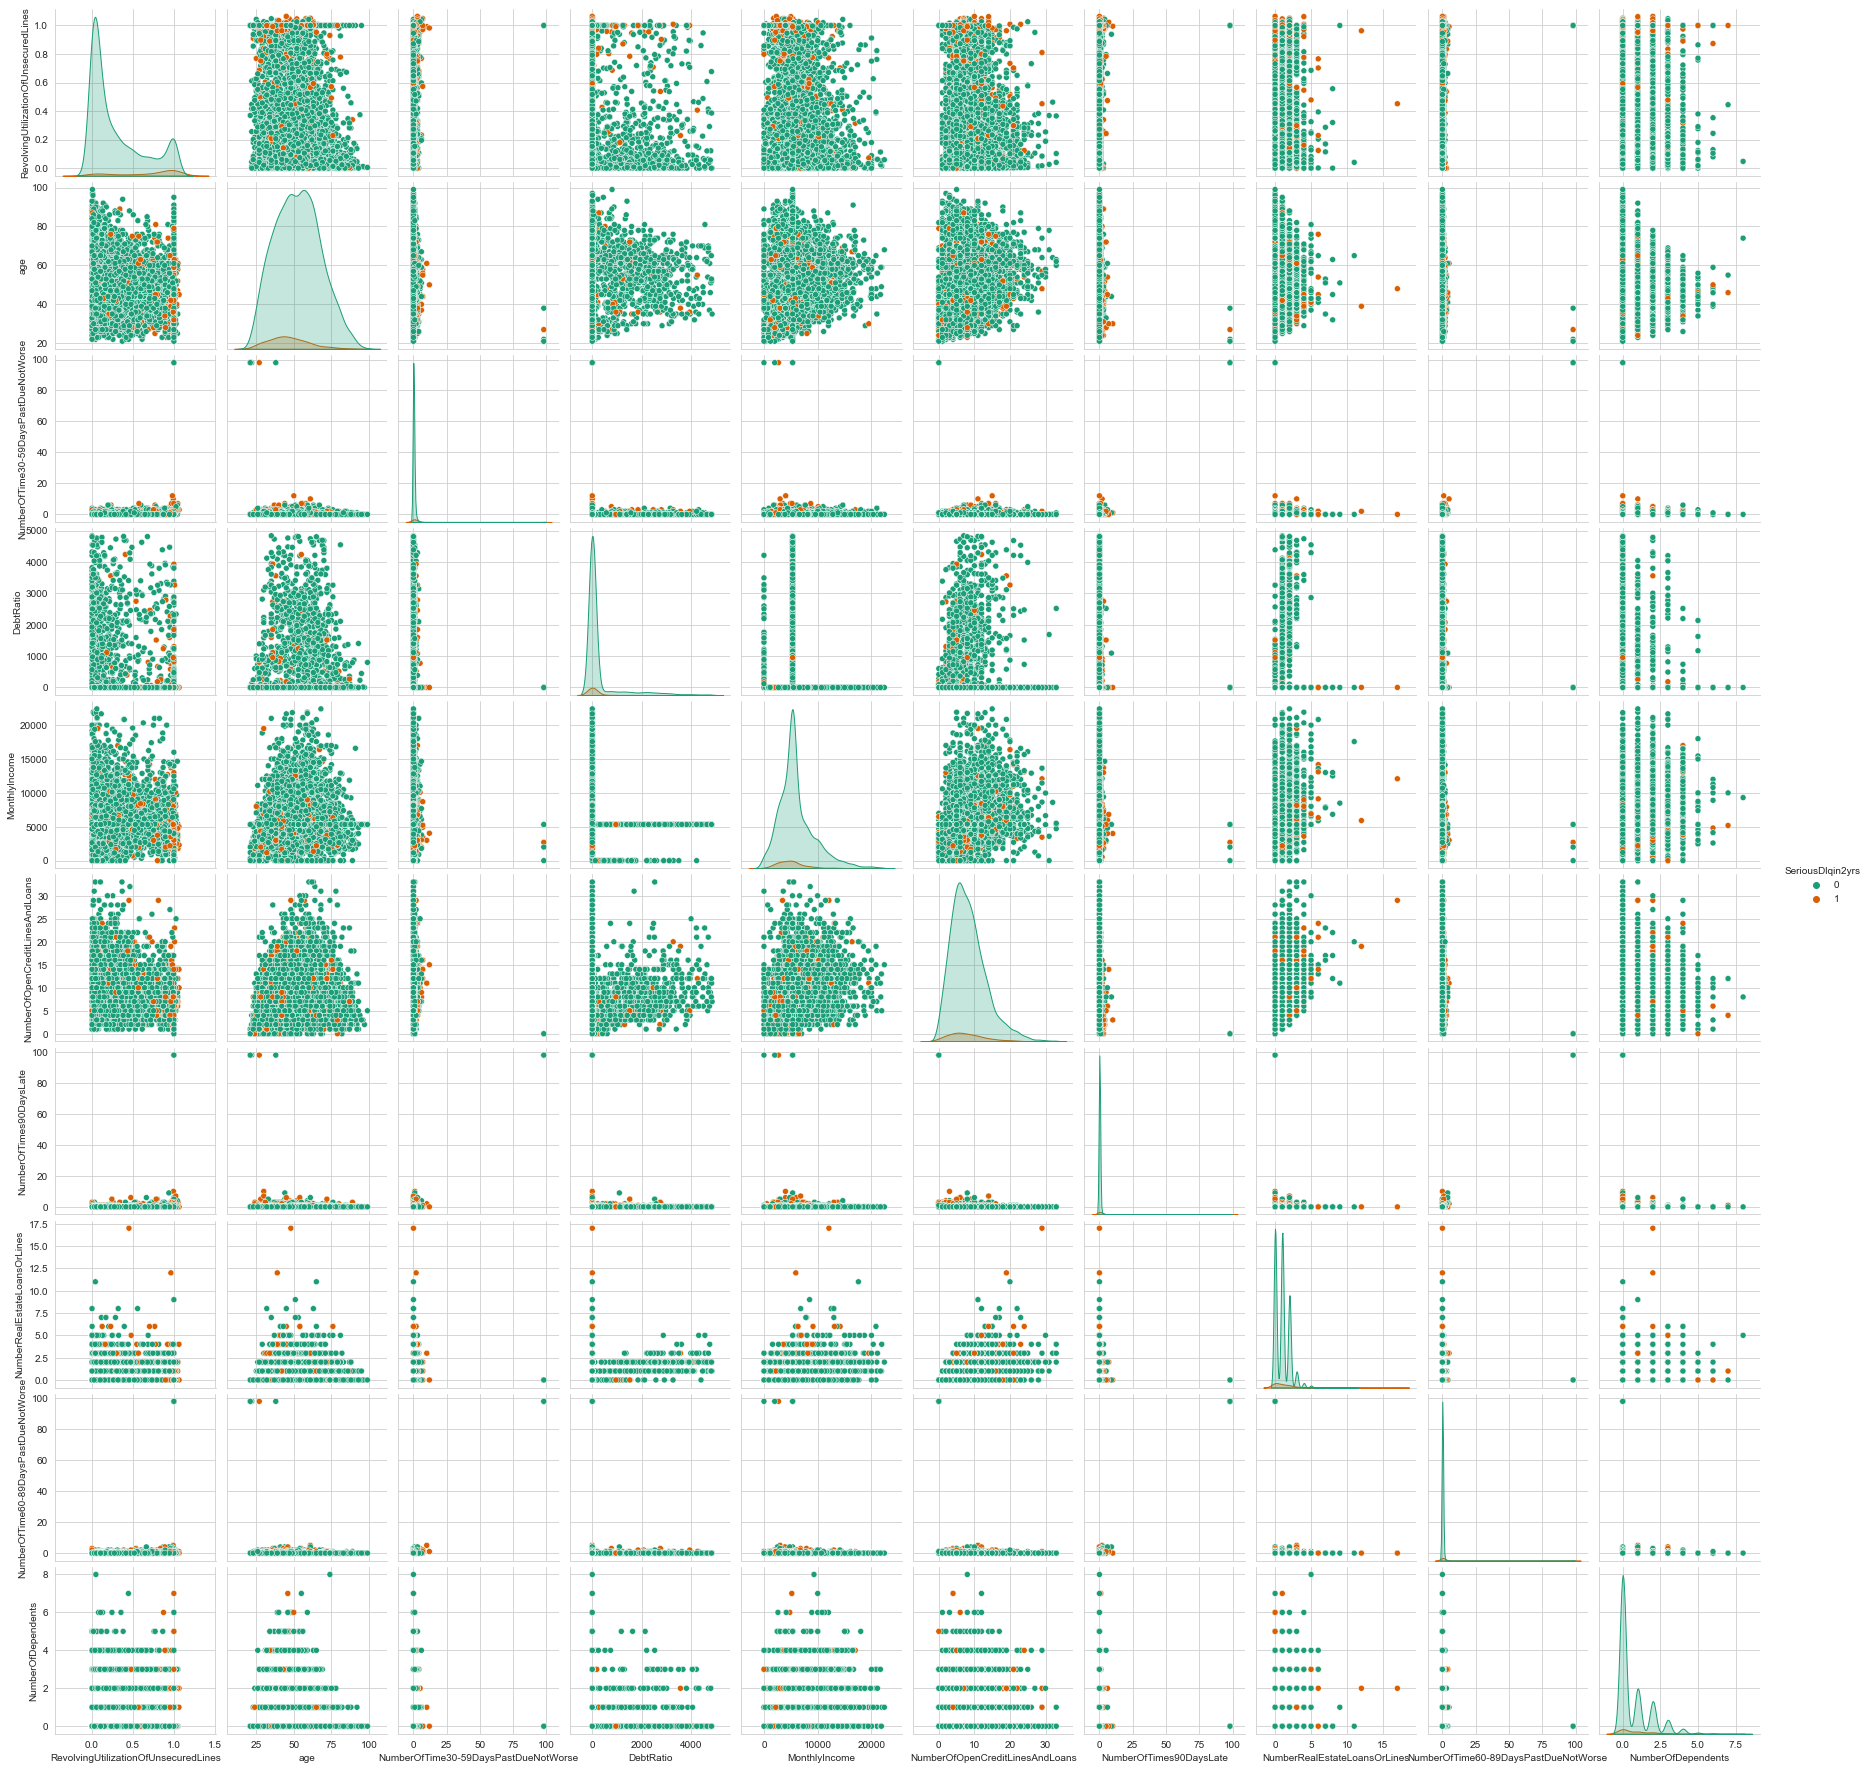

In [22]:
sns.pairplot(training_data,hue='SeriousDlqin2yrs',palette='Dark2');

In [24]:
training_data.keys()

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [ ]:
df[df['class']==1]]['color'] = 'red'
df[df['class'==2]]['color'] = 'blue'
df[df['class'==3]]['color'] = 'blue'

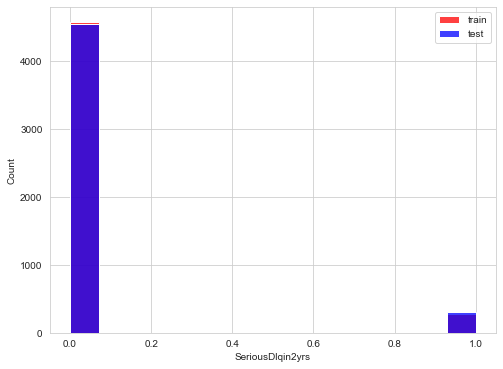

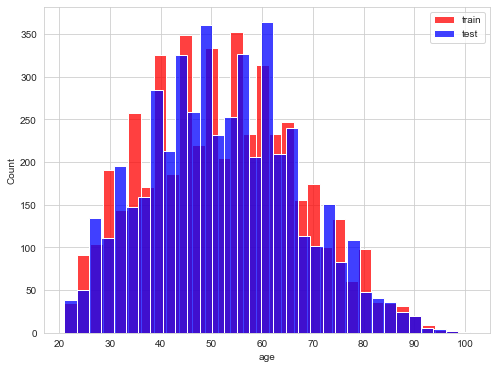

KeyboardInterrupt: 

In [25]:
hist_list = ['SeriousDlqin2yrs', 'age', 'DebtRatio', 'MonthlyIncome']

for idx in hist_list:
    plt.figure(figsize=(8,6));
    sns.histplot(training_data[idx],color='r');
    sns.histplot(test_data[idx],color='b');
    plt.legend(['train','test']);
    plt.show()

Проверим данные на сбалансированность классов.

In [26]:
training_data["SeriousDlqin2yrs"].value_counts()

0    4570
1     281
Name: SeriousDlqin2yrs, dtype: int64

In [27]:
test_data["SeriousDlqin2yrs"].value_counts()

0    4545
1     306
Name: SeriousDlqin2yrs, dtype: int64

Класс отсутствия доминирует в обучающем и тестовом датасетах. Это и логично, пользователи чаще все же возвращают кредиты, чем не возвращают.

## Обучение модели

In [28]:
X_train = training_data.drop("SeriousDlqin2yrs", axis=1)
y_train = training_data["SeriousDlqin2yrs"]

X_test = test_data.drop("SeriousDlqin2yrs", axis=1)
y_test = test_data["SeriousDlqin2yrs"]

Построим дерево решений, классифицирующее наличие просроченной задолженности на обучающей выборке.

In [29]:
# настроим сетку параметров для GridSearch
param_grid = {'criterion': ['gini', 'entropy'],
             'min_samples_split' : [3,5,8,10],
             'min_samples_leaf': [1,3,5,7],
             'max_depth': [3,4,5,6,7,8]
}

Dtree = DecisionTreeClassifier(max_features='auto', random_state=22)

clf = GridSearchCV(Dtree, param_grid=param_grid, cv = 10, n_jobs=-1, return_train_score = False)
clf.fit(X_train, y_train)

# Выведем параметры лучшей модели
clf.best_estimator_

DecisionTreeClassifier(max_depth=4, max_features='auto', min_samples_leaf=7,
                       min_samples_split=3, random_state=22)

In [30]:
# для простоты работы создадим отдельно модель Decision Tree

Dtree = DecisionTreeClassifier(max_depth=4, max_features='auto', min_samples_leaf=7,
                       min_samples_split=3, random_state=22)

Dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, max_features='auto', min_samples_leaf=7,
                       min_samples_split=3, random_state=22)

Посмотрим на точность классификации

In [31]:
print("Обучающая выборка:")
print("\tТочность:\t%.2f%%" % (100 * Dtree.score(X_train, y_train)))
print("\tМеток `0`:\t%.2f%%" % (100 - 100 * np.mean(y_train)))
print()

print("Тестовая выборка:")
print("\tТочность:\t%.2f%%" % (100 * Dtree.score(X_test, y_test)))
print("\tМеток `0`:\t%.2f%%" % (100 - 100 * np.mean(y_test)))

Обучающая выборка:
	Точность:	94.56%
	Меток `0`:	94.21%

Тестовая выборка:
	Точность:	93.49%
	Меток `0`:	93.69%


Точность определения класса `0` почти не отличается от доли класса `0`. Вероятнее всего, модель не смогла выделить закономерности в данных и просто прогнозирует метки в соответствии с их частотой появления.

In [32]:
train_pred = Dtree.predict(X_train)
test_pred = Dtree.predict(X_test)

print(pd.Series(test_pred).value_counts())
print(test_data['SeriousDlqin2yrs'].value_counts())

0    4761
1      90
dtype: int64
0    4545
1     306
Name: SeriousDlqin2yrs, dtype: int64


Посмотрим на распределение предсказанной классификатором вероятности метки `1`.

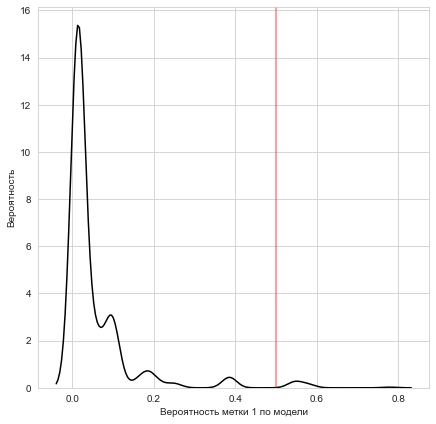

In [33]:
train_prob = Dtree.predict_proba(X_train)[:, 1]
test_prob = Dtree.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(figsize=(7, 7))

ax.set_xlabel('Вероятность метки 1 по модели')
ax.set_ylabel('Вероятность')

sns.kdeplot(test_prob, color='black')
ax.axvline(0.5, color="red", alpha=0.5);

In [34]:
print(f'Только {test_prob[test_prob>0.5].shape[0]} точек с вероятностью больше 0.5')

Только 90 точек с вероятностью больше 0.5


## Таблица сопряжённости классификатора

Таблица сопряжённости (`матрица неточности`, или `Confusion matrix`) содержит сводные показатели качества работы классификатора.

В задачах бинарной классификации один класс называется положительным (тот, на который мы ориентируемся), второй класс негативный.

Общий смысл confusion matrix:

|         |  Прогноз `0` |  Прогноз `1` |
|---------|--------------|--------------|
|Факт `0` |       TN     |       FP     |
|Факт `1` |       FN     |       TP     | 

**TP** — **true positive:** классификатор верно отнёс объект к *положительному* классу.

**TN** — **true negative:** классификатор верно отнес объект не к *положительному* классу.

**FP** — **false positive:** классификатор неверно отнёс объект к *положительному* классу.

**FN** — **false negative:** классификатор неверно отнес объект не к рассматриваемому классу.
    
Посчитаем матрицу для нашего примера

In [35]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, test_pred))
conf_matrix

,0,1
0,4495,50
1,266,40


In [36]:
tn, fp, fn, tp = conf_matrix.values.ravel()

Если сравниваются метрики на разных наборах тестовых данных, то обращают
внимание на доли истинно и ложно позитивных срабатываний классификатора:

* Доля ложно позитивных срабатываний $FPR = \frac{FP}{FP + TN}$;

In [37]:
np.round(fp / (fp + tn),3)

0.011

* Доля истинно позитивных срабатываний $TPR = \frac{TP}{TP + FN}$.

In [38]:
np.round(tp / (tp + fn),3)

0.131

## ROC кривая классификатора

ROC - Receiver Operating Characteristic

Она наглядно показывает зависимость доли истинно позитивных срабатываний TPR от доли ложно позитивных срабатываний FPR при изменении порога классификации.

Классификаторы почти всегда строятся на основе некоторой пороговой функции $f(X) \in \mathbb{R}$ и порога $\tau$:
$$
    \text{model}\bigl(\text{X}\bigr)
        = \begin{cases}
            1 & \text{if }\, f(\text{X}) \geq \tau\,,\\
            0 & \text{else}\,.
        \end{cases}
$$

In [40]:
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, test_prob)

In [83]:
for i,j in zip(y_test, test_prob):
    print(i, ' ', j)

0   0.014420247204237787
0   0.09671532846715329
0   0.05759162303664921
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
1   0.5483870967741935
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.05759162303664921
0   0.014420247204237787
0   0.014420247204237787
0   0.3854166666666667
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.1864406779661017
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.01442024

0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
1   0.3854166666666667
0   0.014420247204237787
0   0.05759162303664921
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.1864406779661017
1   0.05759162303664921
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
1   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.5428571428571428
0   0.014420247204237787
0   0.3854166666666667
0   0.16071428571428573
0   0.014420247204237787
1   0.014420247204237787
0   0.3854166666666667
0   0.3854166666666667
0   0.014420247204237787
1   0.21212121212121213
0   0.014420247204237787
0   0.014420247204237787
1   0.3854166666666667
0   0.014420247204237787
0   0.16071428571428573
0   0.09671532846715329
0   0.25
0   0.05759162303664921
0   0.09671532

0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.5483870967741935
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
1   0.3854166666666667
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
1   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.05759162303664921
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.16071428571428573
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.3854166666666667
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
1   0.1136363

0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.05759162303664921
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.05759162303664921
0   0.5483870967741935
0   0.16071428571428573
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.05759162303664921
0   0.05759162303664921
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.25
0   0.014420247204237787
0   0.014420247204237787
0   0.05759162303664921
0   0.014420247204237787
1   0.5789473684210527
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.0

0   0.014420247204237787
0   0.16071428571428573
1   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.11363636363636363
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
1   0.014420247204237787
1   0.16071428571428573
0   0.014420247204237787
0   0.05759162303664921
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.21212121212121213
0   0.014420247204237787
0   0.3854166666666667
0   0.05759162303664921
0   0.014420247204237787
0   0.014420247204237787
0   0.11363636363636363
0   0.014420247204237787
0   0.05759162303664921
0   0.014420247204237787
0   0.09671532846715329
0   0.014420

0   0.014420247204237787
0   0.014420247204237787
0   0.16071428571428573
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.3854166666666667
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.05759162303664921
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
1   0.05759162303664921
0   0.09671532846715329
0   0.09671532846715329
0   0.014420247204237787
0   0.05759162303664921
0   0.014420247204237787
0   0.014420247204237787
0   0.16071428571428573
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
1   0.5483870967741935
1   0.11363636363636363
0   0.0144202472

0   0.014420247204237787
0   0.09671532846715329
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.05759162303664921
0   0.09671532846715329
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
1   0.09671532846715329
1   0.16071428571428573
0   0.05759162303664921
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.05759162303664921
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.1864406779661017
0   0.014420247204237787
0   0.014420247204237787
1   0.5789473684210527
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247

0   0.1864406779661017
0   0.014420247204237787
0   0.014420247204237787
0   0.3854166666666667
0   0.1864406779661017
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
1   0.5483870967741935
0   0.014420247204237787
1   0.3854166666666667
0   0.014420247204237787
1   0.5789473684210527
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
1   0.3854166666666667
0   0.014420247204

0   0.014420247204237787
0   0.014420247204237787
0   0.05759162303664921
0   0.16071428571428573
0   0.1864406779661017
0   0.014420247204237787
0   0.05759162303664921
0   0.014420247204237787
0   0.014420247204237787
0   0.05759162303664921
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
1   0.014420247204237787
0   0.05759162303664921
0   0.11363636363636363
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.5789473684210527
0   0.05759162303664921
0   0.014420247204237787
0   0.5428571428571428
0   0.014420247204237787
0   0.3854166666666667
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.16071428571428573
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204

0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.05759162303664921
0   0.014420247204237787
0   0.21212121212121213
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.5789473684210527
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
1   0.1864406779661017
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014

0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.09671532846715329
0   0.014420247204237787
0   0.25
1   0.11363636363636363
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.3854166666666667
0   0.014420247204237787
0   0.21212121212121213
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.09671532846715329
0   0.014420247204237787
0   0.014420247204237787
0   0.05759162303664921
0   0.014420247204237787
0   0.16071428571428573
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.05759162303664921
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.014420247204237787
0   0.1864406779661017
0   0.05263157894736842
0   0.014420247204237787
0   0

In [42]:
false_positive_rates

array([0.00000000e+00, 8.80088009e-04, 3.96039604e-03, 8.14081408e-03,
       1.10011001e-02, 2.42024202e-02, 3.05830583e-02, 3.60836084e-02,
       5.89658966e-02, 6.86468647e-02, 7.48074807e-02, 1.92079208e-01,
       2.76347635e-01, 2.77887789e-01, 1.00000000e+00])

Нарисуем кривую

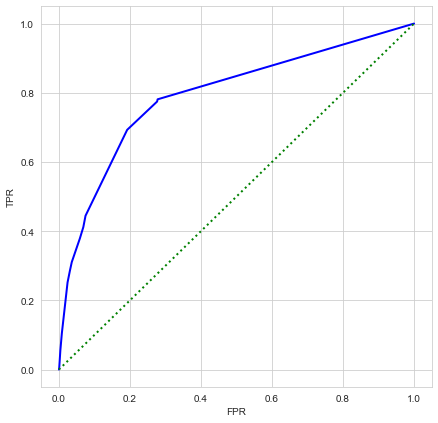

In [43]:
# создаём график
fig = plt.figure(figsize=(7, 7))

plot = fig.add_subplot(xlabel="FPR", ylabel="TPR", )

plot.plot(false_positive_rates, true_positive_rates,
          color='blue', lw=2)
plot.plot([0, 1], [0, 1], color='green', lw=2, linestyle=':');

Исходя из логики построения этого графика, чем ближе кривая ROC к левому верхнему углу, тем лучше качество классификации. Но мы привыкли, что оптимизировать необходимо одну переменную, а с графиком так и вообще работать невозможно. Поэтому существует обобщающая метрика ROC-AUC, которая является площадью под кривой. (AUC - Area Under Curve).
Посчитаем **ROC-AUC** для тестового и обучающего набора данных.

In [44]:
roc_auc = auc(false_positive_rates, true_positive_rates)
print("ROC-AUC тестовая выборка:", np.round(roc_auc,3))

training_false_positive_rates, training_true_positive_rates, _ = roc_curve(y_train, train_prob)
training_roc_auc = auc(training_false_positive_rates, training_true_positive_rates)

print("ROC-AUC обучающая выборка:", np.round(training_roc_auc,3))

ROC-AUC тестовая выборка: 0.794
ROC-AUC обучающая выборка: 0.834


Типичная шкала для **ROC-AUC**:
- **0.90 - 1.00 отлично**
- **0.85 - 0.95 хорошо**
- 0.75 - 0.85 удовлетворительно
- 0.60 - 0.75 плохо
- 0.50 - 0.60 очень плохо
- 0.00 - 0.50 ошибка

Ситуация, когда метрика на тестовой выборке ниже, чем на обучающей почти всегда присутствует, но когда сильное отличие в этих метриках, то говорят про переобучение модели, т.е. сильную подстройку под обучающие данные.

Визуализируем результаты.

Text(0, 0.5, 'Частота истинных срабатываний')

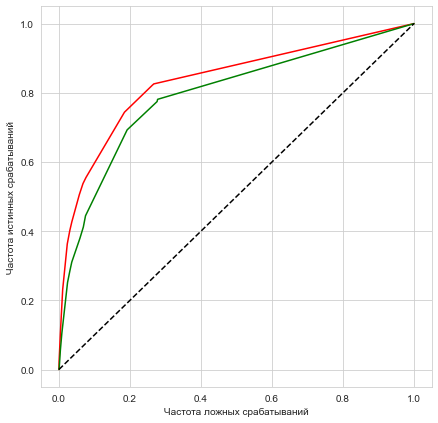

In [45]:
plt.figure(figsize=(7, 7))

plt.plot(training_false_positive_rates, training_true_positive_rates, color='red',
         label='ROC-кривая на обучающих данных (AUC = %0.3f)' % training_roc_auc)

plt.plot(false_positive_rates, true_positive_rates, color='green', 
         label='ROC-кривая на тестовых данных (AUC = %0.3f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.xlabel('Частота ложных срабатываний')
plt.ylabel('Частота истинных срабатываний')

## Точность и полнота

Метрики "Точность" (*Precision*) и "Полнота" (*Recall*) позволяют по-другому взглянуть на качество работы классификатора.

|                   |  Предсказано `0` |  Предсказано `1` |
|-------------------|------------------|------------------|
|**Фактически** `0` |       TN         |       FP         |
|**Фактически** `1` |       FN         |       TP         | 

Несмотря на то, что в Английском языке слова **accuracy** и **precision** близкие синонимы, они соответствуют принципиально разными метрикам.

In [46]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
print("Точность: {:.2%}".format(accuracy))

Точность: 93.49%


Точность классификатора (**Precision**) 

$$\frac{TP}{TP + FP}$$

- отражает насколько разборчиво классификатор присваивает метки положительного класса `1`
- чем выше, тем "реже" объекты, помеченные как `1`, являются на самом деле примерами из класса `0`

In [47]:
precision = tp / (tp + fp)

print("Точность: {:.2%}".format(precision))

Точность: 44.44%


Полнота, **Recall**, классификатора равна доли истинно положительных срабатываний **TPR**

$$\frac{TP}{TP + FN}$$

- "чувствительность" классификатора к объектам положительного
- чем ближе к $1$, тем реже классификатор "пропускает" положительный объект

In [48]:
recall = tp / (tp + fn)

print("Полнота: {:.2%}".format(recall))

Полнота: 13.07%


Если у классификатора
* высокая полнота, но низкая точность -- срабатывает очень часто, однако при этом большинство результатов ошибочны
  - много ложных срабатываний
* низкая полнота, но высокая точность -- срабатывает достаточно редко, но при этом почти безошибочно определяет объекты класса `1`
  - много пропущенных объектов

### Кривая precision-recall

В пространстве **precision-recall** можно построить кривую, аналогичную **ROC**-кривой в пространстве **fpr-tpr**.

In [51]:
training_precision, training_recall, i = precision_recall_curve(y_train, train_prob)
precision, recall, i = precision_recall_curve(y_test, test_prob)

Нарисуем кривые.

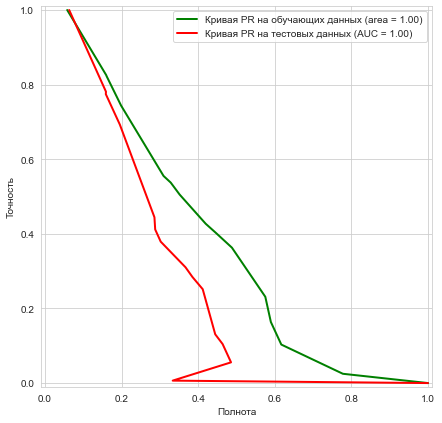

In [53]:
plt.figure(figsize=(7, 7))
line_width = 2

plt.plot(training_precision, training_recall, color='green',
         lw=line_width, label='Кривая PR на обучающих данных (area = %0.2f)' % 1)

plt.plot(precision, recall, color='red',
         lw=line_width, label='Кривая PR на тестовых данных (AUC = %0.2f)' % 1)

plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)

plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.legend(loc="upper right")

plt.show()

Чем ближе кривая **PR** к **правому верхнему** углу тем лучше качество классификации.

Большая площадь под кривой отражает высокие метрики точности и полноты,
что означает низкое число ложных срабатываний, и низкое число пропущенных
объектов интересующего нас класса `1`.

## $F_\beta$ метрика

В общем случае $F_\beta$ рассчитывается как 
$$ F_\beta
    = (1 + \beta^2)
        \frac{\text{Precision} \cdot \text{Recall}}
             {\beta^2 \, \text{Precision} + \text{Recall}}
    = \frac{1 + \beta^2}{\frac{\beta^2}{\text{Recall}} + \frac{1}{\text{Precision}}}
    = \frac{\beta + \beta^{-1}}{\beta\frac{1}{\text{Recall}} + \beta^{-1}\frac{1}{\text{Precision}}}
    \,.
$$

Самая часто используемая метрика -- это $F_1$, которая равна среднему гармоническому точности и полноты
$$
    F_1 = 2 \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
\,. $$

* Среднее гармоническое используется для того, чтобы значения метрики на парах с точностью или полнотой близкой к нулю были очень низкими

* Помимо самих значений точности и полноты, метрика $F_\beta$ также учитывает баланс между ними
  - чем выше **precision** и **recall** и чем ближе они друг к другу, тем выше значение $F_1$ и наоборот
  
* метрика $F_1$ не отражает качество работы классификатора на истинно отрицательных результатах (**TN**)

In [54]:
print(f'F1-метрика train {np.round(f1_score(y_train, train_pred),3)}')
print(f'F1-метрика test {np.round(f1_score(y_test, test_pred),3)}')

F1-метрика train 0.33
F1-метрика test 0.202


Метрика $F_\beta$ хорошо применима для несбалансированной классификации

Нарисуем зависимость метрики $F_1$ от полноты.

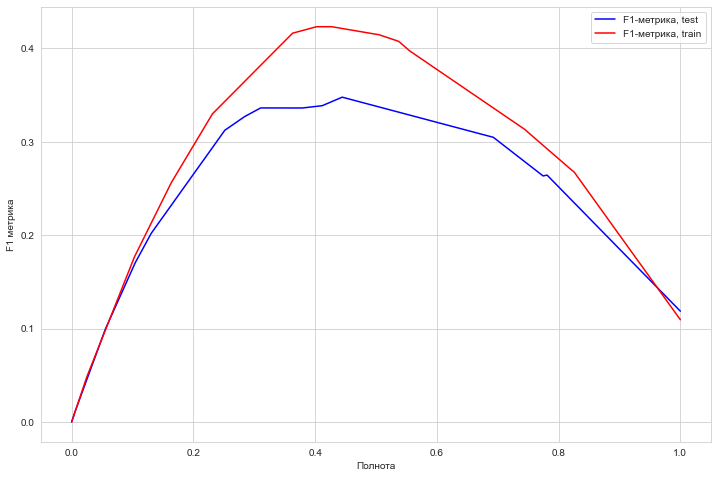

In [55]:
plt.figure(figsize=(12, 8))
plt.plot(recall, 2 * precision * recall / (precision + recall), 
         label='F1-метрика, test', color='blue')

plt.plot(training_recall, 
         2 * training_precision * training_recall / (training_precision + training_recall), 
         label='F1-метрика, train', color='red')

plt.xlabel('Полнота')
plt.ylabel('F1 метрика')

plt.legend()

plt.show()

Сравним точность **accuracy** и метрику $F_1$ обученного классификатора с качеством dummy классификатора.

`dummy` классификатор работает по следующему принципу:
  - оценивается частота $\hat{p}$ класса `1` на обучающей выборке (доля наблюдений класса `1`)
  - каждому тестовому объекту случайно предскажем:
    * метку `1` с вероятностью $\hat{p}$,
    * метку `0` с вероятностью $1 - \hat{p}$.

In [78]:
# создадим объекта класса DummyClassifier
dummy_clf = DummyClassifier(random_state=87)
# обучим наивный классификатор
dummy_clf.fit(X_train, y_train);

Сделаем прогноз меток

In [79]:
rand_pred_test = dummy_clf.predict(X_test)

Рассчитаем метрики наивного классификатора

In [80]:
print(f'Точность решающего дерева\t {np.round(accuracy_score(y_test, test_pred),3)}')
print(f'Точность dummy классификатора\t {np.round(accuracy_score(y_test, rand_pred_test),3)}')

print(f'F1-метрика решающего дерева\t {np.round(f1_score(y_test, test_pred),2)}')
print(f'F1-метрика dummy классификатора\t {np.round(f1_score(y_test, rand_pred_test),5)}')

Точность решающего дерева	 0.935
Точность dummy классификатора	 0.937
F1-метрика решающего дерева	 0.2
F1-метрика dummy классификатора	 0.0


Таблица сопряжённости для случайного классификатора

In [81]:
pd.DataFrame(confusion_matrix(y_test, rand_pred))

,0,1
0,4545,0
1,306,0


Таблица сопряжённости для обученного классификатора

In [70]:
pd.DataFrame(confusion_matrix(y_test, test_pred))

,0,1
0,4495,50
1,266,40


> # Задание 1
>
> Попробовать улушить метрики модели. Использовать ансамбли (случайный лес, градиентный бустинг)

> # Задание 2
>
> Обучите модели МО для датасета MNIST. Посчитайте все метрики, рассмотренные в этой лекции. Сильно ли меняется подход при переходе к многоклассовой классификации?